<a href="https://colab.research.google.com/github/Suderland/analise-sentimento-bert/blob/main/analise_de_sentimento_com_BERT_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Nesse notebook nós vamos prever o sentimento (positivo ou negativo) de um comentário num APP do MeuGov. Para tanto, faremos uso do BERT.

O BERT é um modelo de linguagem baseado no Transformer. Ele é essencialmente o encoder do Transformer, e é muito adequado em casos onde você já tem a mensagem inteira para processar, o que é o caso da análise de sentimentos (mas não é o caso da geração de texto, por exemplo).

Vamos utilizar a implementação de Hugginface. 

## Importando as bibliotecas

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 19.3MB/s 
     |████████████████████████████████| 3.3MB 52.6MB/s 
     |████████████████████████████████| 901kB 55.0MB/s 


In [ ]:
import math
import os
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import Dataset
from transformers import AdamW, BertForSequenceClassification, BertTokenizer
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

## Lendo, Entendendo e Preparando os Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab_Datasets/comment_meugov.csv', sep=';',index_col=0)
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,name,numberStars,comment,date_comment,reponse,date_response,likes
0,Fernando Nassif,1,Seria ótimo se funcionasse. Não é possível faz...,22 de fevereiro de 2021,"1\nPrezado Fernando, é necessário que a foto p...",3 de fevereiro de 202,18.0
1,Antonio Duarte,1,Não consigo de forma alguma finalizar cadastro...,23 de fevereiro de 2021,"1\nPrezado Antônio, lamentamos o transtorno, m...",3 de fevereiro de 202,2.0
2,Magda Maraschin,1,Péssimo APP. Parece pegadinha de TV. Não funci...,27 de janeiro de 2021,"Prezada Magda, uma nova e bem sucedida versão ...",8 de janeiro de 2021\n,148.0
3,Cin Peres,1,"Tentei novamente, diversas e muitas vezes faze...",5 de fevereiro de 2021,"\nPrezado Peres, uma nova e bem sucedida versã...",de fevereiro de 2021,16.0
4,Magdalena Ribeiro CABRAL,1,Já tentei fazer a validação por foto inúmeras ...,3 de fevereiro de 2021,"\nPrezada Magdalena, uma nova e bem sucedida v...",de fevereiro de 2021,10.0


In [ ]:
data['text_pt'] = data['comment'].str.lower()
data = data.drop(['name','date_comment','reponse','date_response','likes'], axis=1)
data.head()

,numberStars,comment,text_pt
0,1,Seria ótimo se funcionasse. Não é possível faz...,seria ótimo se funcionasse. não é possível faz...
1,1,Não consigo de forma alguma finalizar cadastro...,não consigo de forma alguma finalizar cadastro...
2,1,Péssimo APP. Parece pegadinha de TV. Não funci...,péssimo app. parece pegadinha de tv. não funci...
3,1,"Tentei novamente, diversas e muitas vezes faze...","tentei novamente, diversas e muitas vezes faze..."
4,1,Já tentei fazer a validação por foto inúmeras ...,já tentei fazer a validação por foto inúmeras ...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3280 entries, 0 to 3279
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   numberStars  3280 non-null   int64 
 1   comment      3280 non-null   object
 2   text_pt      3280 non-null   object
dtypes: int64(1), object(2)
memory usage: 102.5+ KB


## Adicionando o label pos ou neg

In [ ]:
data['sentiment']='neutro'
data['sentiment'].where(data['numberStars'] < 3 , 'pos', inplace=True)
data['sentiment'].where(data['numberStars'] >= 3  , 'neg', inplace=True)
data.head()

,numberStars,comment,text_pt,sentiment
0,1,Seria ótimo se funcionasse. Não é possível faz...,seria ótimo se funcionasse. não é possível faz...,neg
1,1,Não consigo de forma alguma finalizar cadastro...,não consigo de forma alguma finalizar cadastro...,neg
2,1,Péssimo APP. Parece pegadinha de TV. Não funci...,péssimo app. parece pegadinha de tv. não funci...,neg
3,1,"Tentei novamente, diversas e muitas vezes faze...","tentei novamente, diversas e muitas vezes faze...",neg
4,1,Já tentei fazer a validação por foto inúmeras ...,já tentei fazer a validação por foto inúmeras ...,neg


In [ ]:
# Testes com o dataframe

#data['sentiment']= 'neutro'
#data.loc[data.numberStars >= 4, "sentiment"] = "pos"
#data.loc[data.numberStars < 3, "sentiment"] = "neg"
#data['lbl'] = (data['sentiment'] == 'pos').astype(int) #converte pos e neg para inteiro
#data.head()

In [ ]:
# selecting rows based on condition
#rslt_df = data.loc[data['sentiment']=='neutro']
#print('\nResult dataframe :\n', rslt_df)

Vamos ver a distribuição de classes

In [ ]:
data.groupby('sentiment').count()

,numberStars,comment,text_pt
sentiment,,,
neg,2315,2315,2315
pos,965,965,965


O dataset não está bem balanceado, ficar atento a isso...

Agora vamos ver o comprimento dos comentários. Você pode definir o tamanho de sentença que quiser no BERT, mas o modelo pré-treinado vem com um tamanho pré-definido. No nosso caso vamos utilizar o modelo em português da Neural Mind, que tem 512 tokens de tamanho limite de sentença. Treinar um modelo do zero é muito caro e demorado, por isso é sempre bom partir de um modelo pré-treinado e fazer um fine-tuning. 

Provavelmente existe algum jeito de extender o modelo pré-treinado para um número maior de tokens. Mas, por simplicidade, eu simplesmente usei somente os comentários que tem até 512 tokens, que são a grande maioria. 

O gráfico a seguir mostra o comprimento da sentença. Note que é em caracteres, não em tokens.

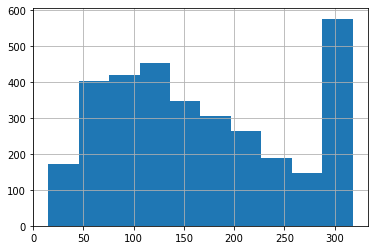

In [ ]:
data['comment'].apply(len).hist()

# Treinamento


## Criando os splits

90/5/5 splits

In [ ]:
test_dev_size = int(0.05*data.shape[0])
train_dev, test = train_test_split(data, test_size=test_dev_size, random_state=42, stratify=data['sentiment'])
train, dev = train_test_split(train_dev, test_size=test_dev_size, random_state=42, stratify=train_dev['sentiment'])
print('Training samples:', train.shape[0])
print('Dev samples:     ', dev.shape[0])
print('Test samples:    ', test.shape[0])

Training samples: 2952
Dev samples:      164
Test samples:     164


## Definindo a classe que vai carregar o nosso dataset

Essa classe vai tokenizar os exemplos e fornecer os pares de inputs e labels para o modelo.

Ela também vai cuidar de criar um cache pra esse dataset, já que tokenizar é bem demorado

In [ ]:

class meuGovPt(Dataset):
    ''' Loads MeuGov-pt dataset. 
    
    It will tokenize our inputs and cut-off those that exceed 512 tokens (the pretrained BERT limit)
    '''
    
    def __init__(self, tokenizer, data, cachefile, rebuild=False):
        if os.path.isfile(cachefile) and rebuild is False:
            self.deserialize(cachefile)
        else:
            self.build(tokenizer, data)
            self.serialize(cachefile)
        
    
    def build(self, tokenizer, data):    
        data = data.copy()
    
        tqdm.pandas()
        data['tokenized'] = data['text_pt'].progress_apply(tokenizer.tokenize)
        
        data['input_ids'] = data['tokenized'].apply(
            lambda tokens: tokenizer.build_inputs_with_special_tokens(
                tokenizer.convert_tokens_to_ids(tokens)))
        
        data = data[data['input_ids'].apply(len)<512]
        
        data['labels'] = (data['sentiment'] == 'pos').astype(int)
        
        self.examples = data[['input_ids', 'labels']].to_dict('records')
    
    def __getitem__(self, i):
        if isinstance(i, int):
            return {key: torch.tensor(value) for key, value in self.examples[i].items()}
        else:
            return [{key: torch.tensor(value) for key, value in sample.items()} for sample in self.examples[i]]
     
    def __len__(self):
        return len(self.examples)
    
    def serialize(self, cachefile):
        with open(cachefile, 'wb') as file:
            pickle.dump(self.examples, file)
    
    def deserialize(self, cachefile):
        with open(cachefile, 'rb') as file:
            self.examples = pickle.load(file)


## Definindo um colador de dados

Essa função recebe um conjunto de exemplos e devolve um mini-batch para passar para rede, ou seja, ele junta os tensores dos exemplos em um batch, cuidando de fazer o padding. Também cuida de incluir uma attention_mask, que indica os tokens que não são padding para o modelo.  

In [ ]:
def data_collator(examples, tokenizer):
    data = {}
    data['input_ids'] = pad_sequence(
            [ex['input_ids'] for ex in examples],
            batch_first=True,
            padding_value=tokenizer.pad_token_id)
    data['labels'] = torch.tensor([ex['labels'] for ex in examples])
    
    attention_mask = torch.zeros(data['input_ids'].shape, dtype=torch.long)
    attention_mask[data['input_ids'] != tokenizer.pad_token_id] = 1   
    data['attention_mask'] = attention_mask
    return data


## Definindo o data loader

Essa classe cuida de carregar o dataset, em mini-batches, para o treinamento da rede

In [ ]:
@dataclass
class DataLoader:
    dataset: meuGovPt
    tokenizer: BertTokenizer
    batch_size: int

    def __iter__(self):
        dataset = self.dataset
        tokenizer = self.tokenizer
        batch_size = self.batch_size
        for start in range(0, len(dataset) - batch_size, batch_size):
            yield data_collator(dataset[start: start+batch_size], tokenizer)

    def __len__(self):
        return math.ceil(len(self.dataset)/self.batch_size)

## Definindo função auxiliares

In [ ]:
def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}


## Preparando os dados para o treino

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
train_dataset = meuGovPt(tokenizer, train, 'train.pkl')
dev_dataset   = meuGovPt(tokenizer, dev,   'dev.pkl')
test_dataset  = meuGovPt(tokenizer, test,  'test.pkl')
print('Preserved: \n\t Train: {:.2f}% \t Dev: {:.2f}% \t Test: {:.2f}%'.format(
    100 * len(train_dataset) / len(train), 
    100 * len(dev_dataset) / len(dev), 
    100 * len(test_dataset) / len(test)))

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

100%|██████████| 2952/2952 [00:01<00:00, 1897.88it/s]
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

100%|██████████| 164/164 [00:00<00:00, 1921.78it/s]
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

100%|██████████| 164/164 [00:00<00:00, 1742.27it/s]


Preserved: 
	 Train: 100.00% 	 Dev: 100.00% 	 Test: 100.00%


Embora tenhamos tirado os exemplos com mais de 512, preservamos a grande maioria.

In [ ]:
train_loader = DataLoader(train_dataset, tokenizer, 8)
dev_loader = DataLoader(dev_dataset, tokenizer, 16)
test_loader = DataLoader(test_dataset, tokenizer, 16)


## Carregando o modelo e otimizador

Aqui nós definimos uma coisa extra que é começar o modelo com a parte pré treinada do BERT congelada. Assim a gente permite aos pesos do layer de classificação se acomodarem antes de começar a fazer o fine-tune na rede toda.

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased')
model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9997)


for param in model.base_model.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

## Treinando o modelo

Aqui vamos fazer a avaliação no devset a cada 200 passos. 
No passo 800 vamos soltar os pesos do modelo base do BERT pra aprender.

In [ ]:
   
def evaluate(model, dev_loader, device):
    with torch.no_grad():
        model.eval()
        dev_losses = []
        tp, tn, fp, fn = [], [], [], []
        for inputs in dev_loader:
            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            dev_losses.append(loss.cpu().item())

            _, classification = torch.max(scores, 1)
            labels = inputs['labels']
            tp.append(((classification==1) & (labels==1)).sum().cpu().item())
            tn.append(((classification==0) & (labels==0)).sum().cpu().item())
            fp.append(((classification==1) & (labels==0)).sum().cpu().item())
            fn.append(((classification==0) & (labels==1)).sum().cpu().item())

        tp_s, tn_s, fp_s, fn_s = sum(tp), sum(tn), sum(fp), sum(fn)
        print('Dev loss: {:.2f}; Acc: {:.2f}; tp: {}; tn: {}; fp: {}; fn: {}'.format( 
              np.mean(dev_losses), (tp_s+tn_s)/(tp_s+tn_s+fp_s+fn_s), tp_s, tn_s, fp_s, fn_s))

        model.train()

In [ ]:
epoch_bar = tqdm_notebook(range(5))
loss_acc = 0
alpha = 0.95
for epoch in epoch_bar:
    batch_bar = tqdm_notebook(enumerate(train_loader), desc=f'Epoch {epoch}', total=len(train_loader))
    for idx, inputs in batch_bar:
        if (epoch * len(train_loader) + idx) == 800:
            for param in model.base_model.parameters():
                param.requires_grad = True

        inputs = send_inputs_to_device(inputs, device)
        optimizer.zero_grad()
        loss, logits = model(**inputs)[:2]
        
        loss.backward()
        optimizer.step()
        if epoch == 0 and idx == 0:
            loss_acc = loss.cpu().item()
        else:
            loss_acc = loss_acc * alpha + (1-alpha) * loss.cpu().item()
        batch_bar.set_postfix(loss=loss_acc)
        if idx%200 == 0:
            del inputs
            del loss
            evaluate(model, dev_loader, device)

        scheduler.step()
    #os.makedirs('/checkpoints/epoch'+str(epoch))
    model.save_pretrained('/content/drive/MyDrive/Colab_Pesos/meuGovSentimentoBert/epoch'+str(epoch))   




Dev loss: 0.72; Acc: 0.31; tp: 46; tn: 4; fp: 110; fn: 0
Dev loss: 0.69; Acc: 0.56; tp: 19; tn: 70; fp: 44; fn: 27



Dev loss: 0.66; Acc: 0.69; tp: 3; tn: 108; fp: 6; fn: 43
Dev loss: 0.64; Acc: 0.72; tp: 2; tn: 113; fp: 1; fn: 44



Dev loss: 0.63; Acc: 0.71; tp: 1; tn: 113; fp: 1; fn: 45
Dev loss: 0.42; Acc: 0.82; tp: 19; tn: 113; fp: 1; fn: 27



Dev loss: 0.26; Acc: 0.91; tp: 40; tn: 105; fp: 9; fn: 6
Dev loss: 0.26; Acc: 0.91; tp: 41; tn: 104; fp: 10; fn: 5



Dev loss: 0.23; Acc: 0.93; tp: 41; tn: 107; fp: 7; fn: 5
Dev loss: 0.22; Acc: 0.93; tp: 41; tn: 107; fp: 7; fn: 5




## Validando o modelo

Agora vamos verificar o desempenho no dev set. Vamos ver a curva ROC e tb qual o melhor threshold de classificação com respeito a nossa métrica escolhida, acurácia

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    labels = []
    for inputs in tqdm_notebook(dev_loader):
        inputs = send_inputs_to_device(inputs, device)
        _, scores = model(**inputs)[:2]
        pred.append(F.softmax(scores, dim=1)[:, 1].cpu())
        labels.append(inputs['labels'].cpu())
pred = torch.cat(pred).numpy()
labels = torch.cat(labels).numpy()


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

fig = px.scatter(
    x=fpr, y=tpr, color=thresholds, 
    labels={'x': 'False positive rate', 'y': 'True positive rate'},
    title='Curva ROC')
fig.show()

In [ ]:
acc = []
for th in thresholds:
    acc.append((~((pred > th) ^ (labels == 1))).sum()/len(labels))

fig2 = px.scatter(
    x=thresholds, y=acc, labels={'x': 'threshold', 'y': 'acurácia'}, 
    title='Acurácia em diferentes thresholds')
fig2.show()  
    

## Avaliação final

Finalmente vamos avaliar o modelo no conjunto de test com o threshold escolhido

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    labels = []
    for inputs in tqdm_notebook(test_loader):
        inputs = send_inputs_to_device(inputs, device)
        _, scores = model(**inputs)[:2]
        pred.append(F.softmax(scores, dim=1)[:, 1].cpu())
        labels.append(inputs['labels'].cpu())
pred = torch.cat(pred).numpy()
labels = torch.cat(labels).numpy()

print('Acc:', (~((pred > 0.67) ^ (labels == 1))).sum()/len(labels))


Acc: 0.91875


# Conclusão

Nesse notebook mostramos como usar o BERT para fazer análise de sentimento. 
Se você gostou do notebook, não esquece de soltar o upvote. 

Vlw!